In [1]:
import torch

# check the version of PyTorch
print(torch.__version__)

2.3.1+cu121


### Create a simple neural network  model for image classification

`torch.nn` (https://pytorch.org/docs/stable/nn.html) is the core module in PyTorch for building neural networks. It provides a comprehensive set of classes and functions to define, train, and evaluate various types of neural network architectures.

 Here's a breakdown of the key components you'll find within `torch.nn`:   

 * Containers 
    * `Module` is Base class for all neural network modules
    * `Sequential` simplifies the construction of feedforward models by stacking layers in a sequential manner
 * Linear, Convolution, Recurrent, Transformer Layers, etc.
 * Activation Functions
 * Loss Functions



In PyTorch, the `Dataset` and `DataLoader` modules from `torch.utils.data` are critical for handling and organizing data for training machine learning models, especially deep learning models. Here's a breakdown of each:
* `Dataset`: The `Dataset` class is an abstract class representing a dataset. It provides a way to define how your data is loaded and processed. In PyTorch, when you want to work with custom datasets (or even standard ones), you usually subclass the `Dataset` class.
* `DataLoader`:  The `DataLoader` class wraps an iterable over the dataset to help efficiently load the data in batches, shuffle it, and handle other details. It simplifies the process of feeding data into your model for training and evaluation. For example, it can group data into batches of a specified size, which is more efficient for training neural networks.

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

`torchvision.transforms.v2` is an extension of the `torchvision.transforms` module, designed to provide more flexible and advanced data augmentation and preprocessing utilities in PyTorch, particularly for computer vision tasks. For example, resizing, normalizing, and flipping images and tensors. 

In [3]:
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

Let us write PyTorch code that works on both GPU (using CUDA) and CPU. It is often called "model-agnostic" because it allows your model to run on either GPU or CPU without changing the rest of the code.

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device) # if "cuda" the model will be moved to the GPU for faster computation

cuda


The rest of this notebook is divided into three parts:

1. Preparing the data
2. Defining and compiling the model
3. Training and evaluating the model

### Part 1: Preparing Data

Torchvision provides many built-in datasets in the `torchvision.datasets` module (https://pytorch.org/vision/0.19/datasets.html)

In [6]:
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True)

In [7]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train


In [8]:
print(valid_set)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test


In [9]:
# what is inside? 

train_set[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [10]:
image, label = train_set[0]

In [11]:
image

In [12]:
type(image) 

PIL.Image.Image

`PIL.Image.Image` is essentially a Python object that encapsulates all the information and properties related to an image

In [13]:
label

5

In [14]:
type(label)

int

In PyTorch, `torchvision.transforms.functional.to_tensor` is a function that converts a given image (in the form of a PIL Image or NumPy array) into a PyTorch tensor. 

In [15]:
image_tensor = F.to_tensor(image)

type(image_tensor)

torch.Tensor

In [16]:
# More efficient way 

trn = transforms.Compose([lambda img: F.to_tensor(img)])

image_tensor = trn(image)

type(image_tensor)


torch.Tensor

In [17]:
image_tensor.max()

tensor(1.)

In [18]:
image_tensor.min()

tensor(0.)

In [19]:
image_tensor.shape # with the shape C, H, W
# C: 3 for RGB images, 1 for grayscale

torch.Size([1, 28, 28])

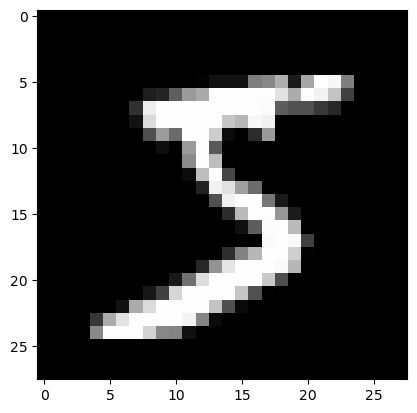

In [20]:
plt.imshow(image_tensor.squeeze(), cmap='gray')
plt.show()

The `transform` attribute allows users to pass custom transformations when they create an instance of the dataset.

In [21]:
train_set.transform = trn
valid_set.transform = trn 

In [22]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # have the data reshuffled at every epoch 
valid_loader = DataLoader(valid_set, batch_size=batch_size)


### Part 2: Defining and Compiling Model

Next, we focus on creating layers for our neural network model.

In [23]:
# Define a small tensor with shape (1, 2, 3)
tensor = torch.tensor([[[1, 2, 3], [4, 5, 6]]])

print("Original tensor shape:", tensor.shape)
print(tensor)

# Define the flatten layer
flatten = nn.Flatten()

# Apply the flatten operation to the tensor
flattened_tensor = flatten(tensor)

print("\nFlattened tensor shape:", flattened_tensor.shape)
print(flattened_tensor)

Original tensor shape: torch.Size([1, 2, 3])
tensor([[[1, 2, 3],
         [4, 5, 6]]])

Flattened tensor shape: torch.Size([1, 6])
tensor([[1, 2, 3, 4, 5, 6]])


In [24]:
layers = [
    nn.Flatten(),
    nn.Linear(1*28*28, 512),  # Input to Hidden 
    nn.ReLU(),  # Activation 
]

print(layers)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=784, out_features=512, bias=True), ReLU()]


Suppose you have an input tensor with the shape `(batch_size, channels, height, width)`, which is a typical shape for images in PyTorch. Applying `Flatten(start_dim=1, end_dim=-1)` to this tensor will flatten all dimensions from the second dimension (channels) to the last dimension (width) into a single dimension.
The output tensor will have the shape `(batch_size, channels * height * width)`.

Next, we will add an additional densely connected linear layer, i.e., hidden layer

In [25]:
layers = [
    nn.Flatten(),
    nn.Linear(1*28*28, 512),  # Input to Hidden
    nn.ReLU(),  # Activation 
    nn.Linear(512, 512),  # Hidden to another Hidden
    nn.ReLU()  # Activation 
]

print(layers)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=784, out_features=512, bias=True), ReLU(), Linear(in_features=512, out_features=512, bias=True), ReLU()]


In [26]:
# Add output layer with 10 nodes 

n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(1*28*28, 512),  # Input to Hidden
    nn.ReLU(),  # Activation 
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation 
    nn.Linear(512, n_classes)  # Output
]

print(layers)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=784, out_features=512, bias=True), ReLU(), Linear(in_features=512, out_features=512, bias=True), ReLU(), Linear(in_features=512, out_features=10, bias=True)]


In Python, the asterisk (*) before a list performs a specific operation called "unpacking". It essentially takes all the elements within the list and "unpacks" them, allowing them to be treated as individual arguments.

In [27]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [28]:
# send the model to "device"

model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

The main goal of `torch.compile` is to speed up model training and inference by optimizing operations under the hood.

In [29]:
model = torch.compile(model)

### Part 3: Training and Evaluating Model

`nn.CrossEntropyLoss()` is a loss function in PyTorch commonly used for classification tasks. It combines two operations: softmax and negative log-likelihood (NLL), making it suitable for multi-class classification problems where the model outputs raw scores (logits) for each class.

In [30]:
loss_function = nn.CrossEntropyLoss()

In [31]:
optimizer = Adam(model.parameters())

In [32]:
# what is inside? 
list(model.parameters())

[Parameter containing:
 tensor([[-0.0339,  0.0098,  0.0346,  ..., -0.0192,  0.0108,  0.0221],
         [ 0.0010,  0.0149,  0.0286,  ...,  0.0304, -0.0043,  0.0332],
         [-0.0138, -0.0283,  0.0089,  ..., -0.0281,  0.0288, -0.0211],
         ...,
         [ 0.0146,  0.0193, -0.0266,  ...,  0.0105,  0.0157, -0.0277],
         [ 0.0180, -0.0153,  0.0279,  ...,  0.0016,  0.0179, -0.0177],
         [ 0.0295,  0.0296, -0.0133,  ...,  0.0016,  0.0210,  0.0203]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0005, -0.0028, -0.0241,  0.0057,  0.0017,  0.0059,  0.0126, -0.0260,
         -0.0124,  0.0002, -0.0113,  0.0144,  0.0067,  0.0213, -0.0032,  0.0054,
          0.0073, -0.0142, -0.0302,  0.0050,  0.0209,  0.0257, -0.0314, -0.0244,
          0.0299, -0.0202,  0.0311, -0.0132, -0.0304, -0.0195, -0.0032,  0.0194,
          0.0209,  0.0209, -0.0268,  0.0024,  0.0187, -0.0353, -0.0137,  0.0247,
         -0.0355, -0.0180, -0.0213,  0.0035, -0.0350,  0.0144,

Next step is to evaluate "accuracy" or the number of correct predictions

In [33]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)
print(train_N, valid_N)

60000 10000


In [34]:
def get_batch_accuracy(output, y, N):
    """
    Calculates the accuracy of predictions in a batch.

    Args:
        output (torch.Tensor): The model's raw output (logits) for the batch, 
                               typically of shape (batch_size, num_classes).
        y (torch.Tensor): The true labels for the batch, of shape (batch_size,).
        N (int): The total number of samples.  

    Returns:
        float: The accuracy of the batch, computed as the number of correct
               predictions divided by the total number of samples (N).

    """ 
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [35]:
def train():
    # Initialize cumulative loss and accuracy for the epoch
    loss = 0
    accuracy = 0

    # Set the model to training mode (important for layers like dropout, etc.)
    model.train()

    # Loop through batches of data from the train_loader
    for x, y in train_loader:
        # Move input data (x) and labels (y) to the specified device (CPU/GPU)
        x, y = x.to(device), y.to(device)

        # Perform a forward pass: compute the model's output for the batch
        output = model(x)

        # Zero out the gradients from the previous step to prevent accumulation
        optimizer.zero_grad()

        # Compute the loss for this batch using the loss function
        batch_loss = loss_function(output, y)

        # Perform backpropagation to compute gradients of the loss with respect to model parameters
        batch_loss.backward()

        # Update the model parameters using the computed gradients
        optimizer.step()

        # Add the batch loss to the cumulative loss for this epoch 
        loss += batch_loss.item()

        # Add the batch accuracy to the cumulative accuracy 
        accuracy += get_batch_accuracy(output, y, train_N)

    # Print the cumulative loss and accuracy for the epoch, formatting the values for clarity
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))


In [36]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x) # no backpropagation needed here 

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [37]:
# Number of epochs to train the model
epochs = 5

# Loop over each epoch
for epoch in range(epochs):
    # Print the current epoch number
    print('Epoch: {}'.format(epoch))
    
    # Call the train function to train the model for one epoch
    train()
    
    # Call the validate function to evaluate the model's performance on the validation set
    validate()


Epoch: 0


/home/farhad/anaconda3/envs/mytorch/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Train - Loss: 380.1629 Accuracy: 0.9372
Valid - Loss: 32.7596 Accuracy: 0.9685
Epoch: 1
Train - Loss: 155.8399 Accuracy: 0.9747
Valid - Loss: 29.7611 Accuracy: 0.9683
Epoch: 2
Train - Loss: 110.7205 Accuracy: 0.9813
Valid - Loss: 22.1214 Accuracy: 0.9785
Epoch: 3
Train - Loss: 79.7786 Accuracy: 0.9861
Valid - Loss: 24.2450 Accuracy: 0.9768
Epoch: 4
Train - Loss: 66.8988 Accuracy: 0.9881
Valid - Loss: 22.0565 Accuracy: 0.9801


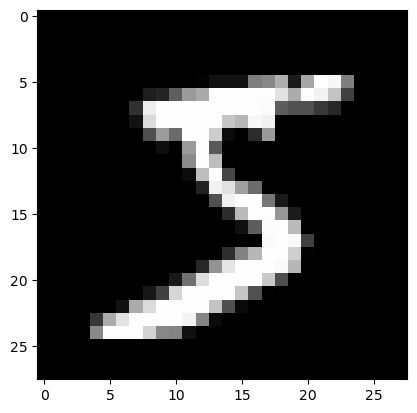

In [38]:
plt.imshow(image_tensor.squeeze(), cmap='gray')

In [39]:
model(image_tensor.to(device))

tensor([[-23.4364, -14.2583, -14.1827,   4.2504, -20.3917,  20.2187, -11.8518,
         -18.2072, -11.3152,  -7.4485]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)

In [42]:
model(image_tensor.to(device)).argmax(dim=1)

tensor([5], device='cuda:0')